## Libraries and Dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
import re
from sklearn.model_selection import train_test_split

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [3]:
matplotlib.style.use('seaborn-white')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
matplotlib.rcParams["font.weight"] = "bold"
matplotlib.rc('axes', labelsize=14, titlesize=14)
matplotlib.rc('legend', fontsize=14)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)

colors = ['#40128B','#DD58D6']

In [4]:
df = pd.read_csv("C:/Users/HP/FOR PRIMARY THINGS/Question-Pair ( NLP )/train.csv")

In [5]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
58129,58129,48102,102042,"Will there be another big World War? If so, wh...",Are we going to see the next world war?,1
325454,325454,451704,209580,Why did oil prices fall again in 2015?,Why did oil prices plummet in 2014 and 2015?,1
334480,334480,461654,80639,Who would be king if Prince Charles dies befor...,Does Queen Elizabeth II own 1/6 of Earth’s land?,0
318542,318542,443906,443907,How can I improve my business skills?,What can I do to improve my business skills?,1
268653,268653,386255,386256,What is the actual chronological order of the ...,What is your review of Terminator Genisys (201...,0
97734,97734,162560,162561,Why should I buy vs. lease a luxury car?,Is it better to buy or lease a luxury sports car?,1
19320,19320,36510,36511,What is the one thing you regret doing or not ...,What is the one thing you regret not doing in ...,1
360812,360812,47244,89340,How does one become a celebrity?,What is the easiest way to become a celebrity?,1
71355,71355,122803,122804,What are the ways to spread atheism?,What is the best way for a 25 y o student with...,0
255101,255101,38442,8378,Has anyone tried to harness the energy from li...,Can we harness electrical power from the light...,1


In [6]:
df.shape

(404290, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

## EDA - I

* ##### As the dataset is very large, we can drop those rows

In [9]:
df.dropna(inplace = True)

In [10]:
# Distribution of duplicate and non-duplicate questions

duplicate = df[df['is_duplicate'] == 1]
non_duplicate = df[df['is_duplicate'] == 0]

print(duplicate.shape)
print(non_duplicate.shape)

(149263, 6)
(255024, 6)


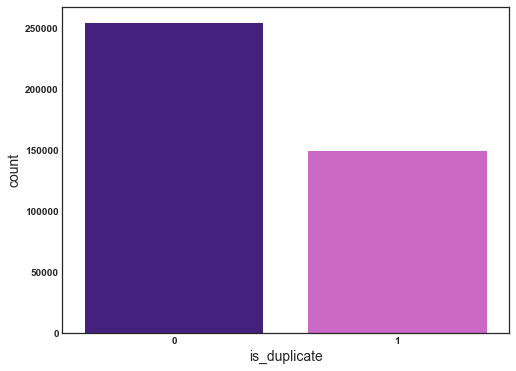

In [11]:
sns.countplot(df['is_duplicate'] , palette = colors);

* ##### 64% of data is non-duplicate , and 36% is duplicate. But as the data is human-made their may be possibility of error.

In [12]:
# Repeated Questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions : ',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated : ',x[x].shape[0])

Number of unique questions :  537929
Number of questions getting repeated :  111778


* ##### By combining both questions id 1&2 around 63% of questions are unique.

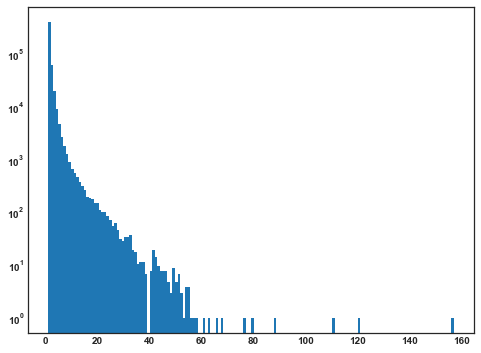

In [13]:
# Repeated questions Histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

* ##### Generally, more than 80% falls between 0-45 , so question repeated becomes less and less as goes on.

In [14]:
new_df = df.sample(30000)

## Text Preprocessing

In [15]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [16]:
def preprocess(q):
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    q = q.replace('&', ' and ')
    
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents 
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    # Tokenize Words
    words = word_tokenize(q)
    
    q = " ".join(words)
    return q
    

In [17]:
preprocess("I've already! wasn't <b>done</b>?")

'I have already was not done'

In [18]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [19]:
new_df

,id,qid1,qid2,question1,question2,is_duplicate
398532,398532,531762,110815,On average how many Hollywood films are releas...,What are the best Hollywood movies of 2015,0
321088,321088,446745,247520,Is you ai not shit a compliment or insult,What is the best compliment a girl can get for...,0
87970,87970,148060,148061,Is there any app to lock WhatsApp s particular...,What is the difference between WeChat and What...,0
382759,382759,12956,36473,Have the Ancient Mayans been scientifically te...,Has Ancient Egypt been scientifically tested,1
195718,195718,296245,296246,How is noise pollution caused,What are the causes of noise pollution,1
...,...,...,...,...,...,...
238512,238512,349889,349890,What can I do after competing B Sc in Chemistr...,What can I do after a B Sc with physics,1
400264,400264,31848,187194,How does the Queen of the United Kingdom trave...,If the Queen of the United Kingdom dies would ...,0
152705,152705,239863,239864,What is the work of mathematician,Who is a mathematician,0
365790,365790,495930,495931,Should I confess my affair,Should I confess an affair that is over,0


## Feature Engineering

### Basics
***

* #### Length of Question 1 & 2

In [20]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

* #### Number of Words in Question 1 & 2

In [21]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))

* #### Common Words in Question 1 & 2

In [22]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip() , row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() , row['question2'].split(" ")))
    return len(w1 & w2)

In [23]:
new_df['common_word'] = new_df.apply(common_words , axis=1)

* #### Total Words in Question 1 & 2

In [24]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip() , row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() , row['question2'].split(" ")))
    return (len(w1) +  len(w2))

In [25]:
new_df['word_total'] = new_df.apply(common_words , axis=1)

* #### Word shared between Question 1 & 2

In [26]:
new_df['word_share'] = round(new_df['common_word']/new_df['word_total'],2)

In [27]:
new_df.head(8)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,word_total,word_share
398532,398532,531762,110815,On average how many Hollywood films are releas...,What are the best Hollywood movies of 2015,0,58,42,11,8,2,19,0.11
321088,321088,446745,247520,Is you ai not shit a compliment or insult,What is the best compliment a girl can get for...,0,41,56,9,12,3,21,0.14
87970,87970,148060,148061,Is there any app to lock WhatsApp s particular...,What is the difference between WeChat and What...,0,62,50,12,8,3,20,0.15
382759,382759,12956,36473,Have the Ancient Mayans been scientifically te...,Has Ancient Egypt been scientifically tested,1,50,44,7,6,4,13,0.31
195718,195718,296245,296246,How is noise pollution caused,What are the causes of noise pollution,1,29,38,5,7,2,12,0.17
135423,135423,1749,92977,How can changing 500 and 1k rupee notes end th...,How does the latest decision of abolishing 500...,1,68,101,14,17,7,30,0.23
141818,141818,225041,225042,How can I make my newly published book to be k...,If Libertarianism is so great why are not ther...,0,118,75,25,12,0,30,0.00
36888,36888,67205,67206,How to make an Aztec headdress,What did the Aztecs think of life,0,30,33,6,7,0,13,0.00


### Advanced
***

> #### Token Feature

* cwc_min: This is the ratio of the number of common words to the length of the smaller question
* cwc_max: This is the ratio of the number of common words to the length of the larger question
* csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
* csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
* ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
* ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
* last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
* first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

In [28]:
from nltk.corpus import stopwords 

def fetch_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    Safe_DIV = 0.0001
    
    stop_words = stopwords.words("english")
    
    token_features = [0.0]*8   # return this as a row if any problem occurs during feature
    
    # Converting the sentences into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens)==0 or len(q2_tokens)==0 :
        return token_features
                                                          
    
    # Non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    
    # Stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
           
           
    # Common non-stopwords from Question Pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Common stopwords from Question Pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Common token from Question Pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count/(min(len(q1_words) , len(q2_words)) + Safe_DIV)
    token_features[1] = common_word_count/(max(len(q1_words) , len(q2_words)) + Safe_DIV)
    token_features[0] = common_stop_count/(min(len(q1_stops) , len(q2_stops)) + Safe_DIV)
    token_features[0] = common_word_count/(max(len(q1_stops) , len(q2_stops)) + Safe_DIV)
    token_features[0] = common_token_count/(min(len(q1_tokens) , len(q2_tokens)) + Safe_DIV)
    token_features[0] = common_token_count/(max(len(q1_tokens) , len(q2_tokens)) + Safe_DIV)
    
    
    # Last Word of both question same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First Word of both questions same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    
    return token_features

In [29]:
token_features = new_df.apply(fetch_features , axis=1)

new_df['cwc_min'] = list(map(lambda x: x[0] , token_features))
new_df['cwc_max'] = list(map(lambda x: x[1] , token_features))
new_df['csc_min'] = list(map(lambda x: x[2] , token_features))
new_df['csc_max'] = list(map(lambda x: x[3] , token_features))
new_df['ctc_min'] = list(map(lambda x: x[4] , token_features))
new_df['ctc_max'] = list(map(lambda x: x[5] , token_features))
new_df['last_word_eq'] = list(map(lambda x: x[6] , token_features))
new_df['first_word_eq'] = list(map(lambda x: x[7] , token_features))

In [30]:
new_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398532,398532,531762,110815,On average how many Hollywood films are releas...,What are the best Hollywood movies of 2015,0,58,42,11,8,...,19,0.11,0.181817,0.142855,0.0,0.0,0.0,0.0,0.0,0.0
321088,321088,446745,247520,Is you ai not shit a compliment or insult,What is the best compliment a girl can get for...,0,41,56,9,12,...,21,0.14,0.166665,0.166664,0.0,0.0,0.0,0.0,0.0,0.0
87970,87970,148060,148061,Is there any app to lock WhatsApp s particular...,What is the difference between WeChat and What...,0,62,50,12,8,...,20,0.15,0.166665,0.142855,0.0,0.0,0.0,0.0,0.0,0.0


> #### Length Based Feature

* mean_len: Mean of the length of the two questions (number of words)
* abs_len_diff: Absolute difference between the length of the two questions (number of words)
* longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

In [31]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    
    if strs:
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        # Assign a specific value (e.g., -1) when no common substrings are found
        length_features[2] = -1.0
    
    return length_features

In [32]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0] , length_features))
new_df['mean_len'] = list(map(lambda x: x[1] , length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2] , length_features))

* #### EDA - II

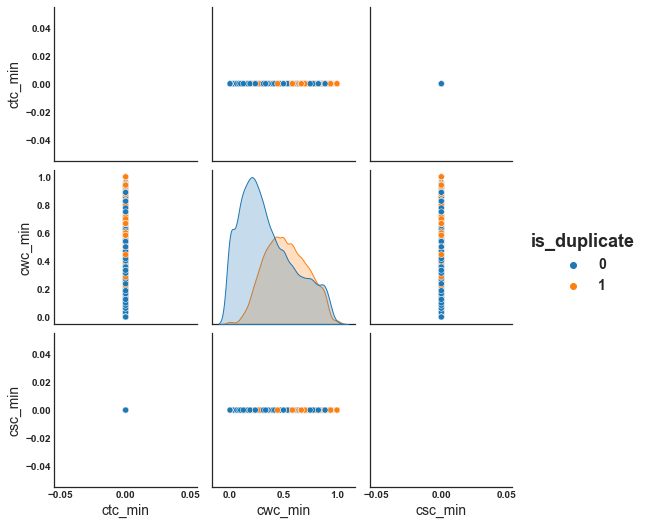

In [33]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

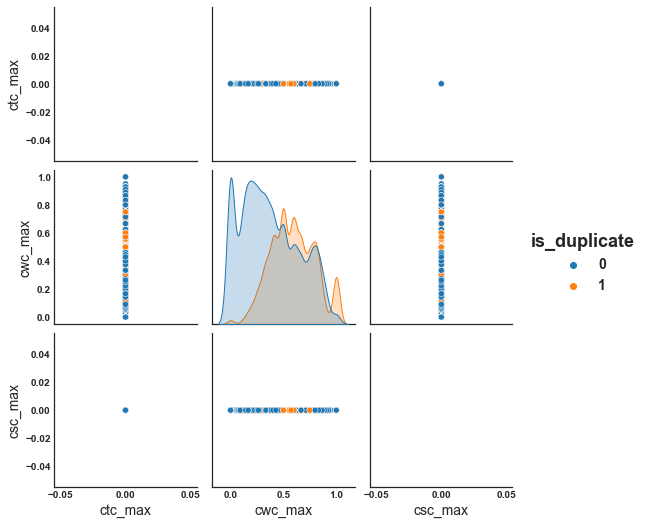

In [34]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

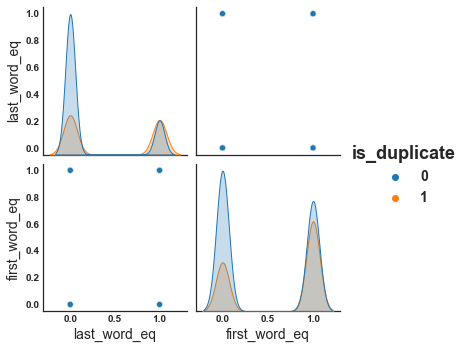

In [35]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

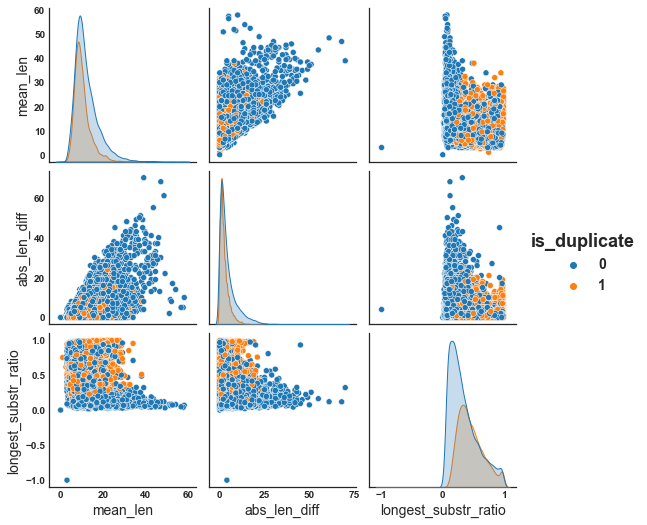

In [36]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

## NLP Models
***

In [37]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
398532,On average how many Hollywood films are releas...,What are the best Hollywood movies of 2015
321088,Is you ai not shit a compliment or insult,What is the best compliment a girl can get for...
87970,Is there any app to lock WhatsApp s particular...,What is the difference between WeChat and What...
382759,Have the Ancient Mayans been scientifically te...,Has Ancient Egypt been scientifically tested
195718,How is noise pollution caused,What are the causes of noise pollution


In [38]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 19)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398532,0,58,42,11,8,2,19,0.11,0.181817,0.142855,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.5,0.255814
321088,0,41,56,9,12,3,21,0.14,0.166665,0.166664,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.5,0.285714
87970,0,62,50,12,8,3,20,0.15,0.166665,0.142855,0.0,0.0,0.0,0.0,0.0,0.0,4.0,10.0,0.176471
382759,1,50,44,7,6,4,13,0.31,0.571420,0.599988,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.5,0.600000
195718,1,29,38,5,7,2,12,0.17,0.285710,0.499988,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.533333


* #### BOW

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features = 3000)
q1_arr , q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [40]:
temp_df1 = pd.DataFrame(q1_arr , index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr , index=ques_df.index)

temp_df = pd.concat([temp_df1,temp_df2],axis=1)

In [41]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
321088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
382759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
final_df_bow = pd.concat([final_df, temp_df], axis=1)
final_df_bow.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398532,0,58,42,11,8,2,19,0.11,0.181817,0.142855,...,0,0,0,0,0,0,0,0,0,0
321088,0,41,56,9,12,3,21,0.14,0.166665,0.166664,...,0,0,0,0,0,0,0,0,0,0
87970,0,62,50,12,8,3,20,0.15,0.166665,0.142855,...,0,0,0,0,0,0,0,0,0,0
382759,1,50,44,7,6,4,13,0.31,0.571420,0.599988,...,0,0,0,0,0,0,0,0,0,0
195718,1,29,38,5,7,2,12,0.17,0.285710,0.499988,...,0,0,0,0,0,0,0,0,0,0


* #### TF-IDF

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

questions = list(ques_df['question1']) + list(ques_df['question2'])

idf = TfidfVectorizer(max_features = 3000)
q1_arr , q2_arr = np.vsplit(idf.fit_transform(questions).toarray(),2)

In [44]:
temp_df1_idf = pd.DataFrame(q1_arr , index=ques_df.index)
temp_df2_idf = pd.DataFrame(q2_arr , index=ques_df.index)

temp_df_idf = pd.concat([temp_df1_idf,temp_df2_idf],axis=1)
print(temp_df_idf.shape)

(30000, 6000)


In [45]:
temp_df_idf.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
321088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
final_df_idf = pd.concat([final_df, temp_df_idf], axis=1)
final_df_idf.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398532,0,58,42,11,8,2,19,0.11,0.181817,0.142855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
321088,0,41,56,9,12,3,21,0.14,0.166665,0.166664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87970,0,62,50,12,8,3,20,0.15,0.166665,0.142855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382759,1,50,44,7,6,4,13,0.31,0.571420,0.599988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195718,1,29,38,5,7,2,12,0.17,0.285710,0.499988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* #### Train Test Spliting

> #### BOW 

In [47]:
x_bow = final_df_bow.iloc[:,1:].values
y_bow = final_df_bow.iloc[:,0].values

In [48]:
x_bow.shape

(30000, 6018)

In [49]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x_bow ,y_bow ,test_size=0.2,random_state=42)

> #### TF-IDF

In [50]:
x_idf = final_df_idf.iloc[:,1:].values
y_idf = final_df_idf.iloc[:,0].values

In [51]:
from sklearn.model_selection import train_test_split
X_train_idf,X_test_idf,y_train_idf,y_test_idf = train_test_split(x_idf ,y_idf ,test_size=0.2,random_state=42)

## ML Models
***

* #### Random Forest 

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [53]:
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7763333333333333

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_idf,y_train_idf)

RandomForestClassifier()

In [55]:
y_pred = rf.predict(X_test_idf)
accuracy_score(y_test_idf,y_pred)

0.7701666666666667

* #### Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [57]:
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.716


In [58]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_idf, y_train_idf)

DecisionTreeClassifier(random_state=42)

In [59]:
y_pred = dt_classifier.predict(X_test_idf)
accuracy = accuracy_score(y_test_idf, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7108333333333333


* #### XGBoost

In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [61]:
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7676666666666667

In [62]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_idf,y_train_idf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [63]:
y_pred1 = xgb.predict(X_test_idf)
accuracy_score(y_test_idf,y_pred1)

0.7648333333333334

* #### Predicting Outcome

In [64]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [65]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [66]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [67]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features


In [68]:
def predicting_function(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,18),q1_bow,q2_bow))

In [69]:
q1 = 'Where is the capital of India?'
q2 = 'What is the business capital of India?'

In [70]:
rf.predict(predicting_function(q1,q2))

array([0], dtype=int64)

In [73]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))